In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
SPY = yf.download('SPY') # SPDR S&P 500 trust ETF

## choose the best representative consumer staples ETF
XLP = yf.download('XLP') # Consumer Staples Select Sector SPDR Fund
VDC = yf.download('VDC') # Vanguard Consumer Staples ETF
FSTA = yf.download('FSTA') # Fidelity MSCI Consumer Staples Index ETF
KXI = yf.download('KXI') # iShares Global Consumer Staples ETF
RHS = yf.download('RHS') # Invesco S&P 500 Equal Weight Consumer Staples ETF

## the frequency is daily, and it's enough

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
## Merge Covid Cases to consumer staples data set by dates to analyze how cases influence ETF prices (e.g. lag the prices by 30 days)
# New York Times Covid Cases Tracking Source: https://github.com/nytimes/covid-19-data
csv_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
us_covid = pd.read_csv(csv_url)

us_covid['new_cases'] = us_covid['cases']-us_covid['cases'].shift(1)
us_covid['new_deaths'] = us_covid['deaths']-us_covid['deaths'].shift(1)
list(us_covid)

['date', 'cases', 'deaths', 'new_cases', 'new_deaths']

In [4]:
## Merge treasury bonds as well. Goal is to study correlation between ETF&bonds for hedging strategies.
# country codes for bonds related to United States and UK are 'U.S.' and 'U.K.' respectively
# inflation rate
import investpy

US_2y_bonds = investpy.get_bond_historical_data(bond='U.S. 2Y', from_date='21/01/2020', to_date='15/08/2021')
US_10y_bonds = investpy.get_bond_historical_data(bond='U.S. 2Y', from_date='21/01/2020', to_date='15/08/2021')

In [5]:
US_10y_bonds.shape

(471, 4)

In [6]:
ETF_data = yf.download("SPY XLP VDC FSTA KXI RHS", start="2020-01-21", end="2021-08-15")
cstaple_data = yf.download("BG TSN SPB TGT SAM HLF DAR COTY", start="2020-01-21", end="2021-08-15")

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  8 of 8 completed


In [7]:
ETF_data.shape # 399 trading days selected, 6*8 variables

(396, 36)

In [8]:
cstaple_data.shape 

(396, 48)

In [9]:
us_covid.shape # only has trading days, it matches with the bonds

(574, 5)

In [10]:
# change index back to bonds
# ETF_data['date']=ETF_data['Open'].index.to_frame().reset_index(drop=True)
# US_10y_bonds['date']=US_10y_bonds['Open'].index.to_frame().reset_index(drop=True)

In [11]:
# make the date column the index of us_covid
us_covid=us_covid.set_index('date')

In [12]:
# merge the dataframes by index
US_10y_bonds.columns=['10ybond_Open', '10ybond_High', '10ybond_Low', '10ybond_Close']
US_2y_bonds.columns=['2ybond_Open', '2ybond_High', '2ybond_Low', '2ybond_Close']
merge=pd.merge(ETF_data,US_10y_bonds, how='inner', left_index=True, right_index=True) # merge by index
merge=pd.merge(merge,US_2y_bonds, how='inner', left_index=True, right_index=True) # merge by index
ETF_bonds_covid=pd.merge(merge,us_covid, how='inner', left_index=True, right_index=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [13]:
ETF_bonds_covid.head

<bound method NDFrame.head of             (Adj Close, FSTA)  (Adj Close, KXI)  (Adj Close, RHS)  \
2020-01-21          36.843975         54.378551        144.040649   
2020-01-22          36.872814         54.417137        143.768295   
2020-01-23          36.795914         54.253147        143.933655   
2020-01-24          36.555607         54.108440        142.737213   
2020-01-27          36.392197         53.606815        142.046570   
...                       ...               ...               ...   
2021-08-09          43.189999         61.639999        158.699997   
2021-08-10          43.500000         61.779999        160.169998   
2021-08-11          43.639999         62.029999        160.889999   
2021-08-12          43.560001         62.060001        160.330002   
2021-08-13          43.910000         62.619999        161.979996   

            (Adj Close, SPY)  (Adj Close, VDC)  (Adj Close, XLP)  \
2020-01-21        323.107697        157.309921         61.552689   
2020-

In [14]:
# 1.the correlation of between consumer staple ETFs, Covid cases, and deaths
ETF_data_adjclose=pd.concat([ETF_bonds_covid['Adj Close', 'SPY'], ETF_bonds_covid['Adj Close', 'XLP'], ETF_bonds_covid['Adj Close', 'VDC'], ETF_bonds_covid['Adj Close', 'FSTA'],ETF_bonds_covid['Adj Close', 'KXI'], ETF_bonds_covid['Adj Close', 'RHS'], ETF_bonds_covid['cases'], ETF_bonds_covid['deaths'], ETF_bonds_covid['10ybond_Close'], ETF_bonds_covid['2ybond_Close'], ETF_bonds_covid['new_cases'], ETF_bonds_covid['new_deaths']], axis=1)
ETF_data_adjclose.corr() # output the correlation of each of two columns

,"(Adj Close, SPY)","(Adj Close, XLP)","(Adj Close, VDC)","(Adj Close, FSTA)","(Adj Close, KXI)","(Adj Close, RHS)",cases,deaths,10ybond_Close,2ybond_Close,new_cases,new_deaths
"(Adj Close, SPY)",1.000000,0.967107,0.979748,0.978817,0.970675,0.968452,0.940833,0.946987,-0.236994,-0.236994,0.313792,0.043262
"(Adj Close, XLP)",0.967107,1.000000,0.997125,0.997208,0.991155,0.981202,0.864688,0.874204,-0.194090,-0.194090,0.346416,0.018247
"(Adj Close, VDC)",0.979748,0.997125,1.000000,0.999831,0.989013,0.986254,0.895488,0.903214,-0.213641,-0.213641,0.342911,0.038643
"(Adj Close, FSTA)",0.978817,0.997208,0.999831,1.000000,0.988709,0.986065,0.895351,0.901708,-0.205609,-0.205609,0.338978,0.035075
"(Adj Close, KXI)",0.970675,0.991155,0.989013,0.988709,1.000000,0.981880,0.859534,0.868384,-0.160636,-0.160636,0.315527,-0.003439
"(Adj Close, RHS)",0.968452,0.981202,0.986254,0.986065,0.981880,1.000000,0.879793,0.886679,-0.153588,-0.153588,0.246488,-0.009033
cases,0.940833,0.864688,0.895488,0.895351,0.859534,0.879793,1.000000,0.991423,-0.356687,-0.356687,0.289996,0.119530
deaths,0.946987,0.874204,0.903214,0.901708,0.868384,0.886679,0.991423,1.000000,-0.427151,-0.427151,0.274904,0.099731
10ybond_Close,-0.236994,-0.194090,-0.213641,-0.205609,-0.160636,-0.153588,-0.356687,-0.427151,1.000000,1.000000,-0.362838,-0.401697
2ybond_Close,-0.236994,-0.194090,-0.213641,-0.205609,-0.160636,-0.153588,-0.356687,-0.427151,1.000000,1.000000,-0.362838,-0.401697


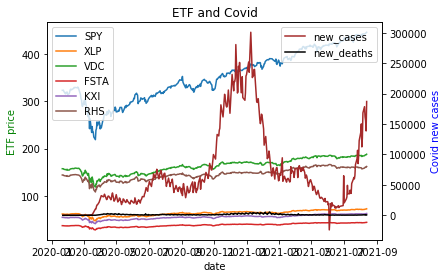

In [15]:
# 2. plot the indices' change in price to review the trend 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ETF_bonds_covid['Adj Close', 'SPY'],label='SPY')
ax1.plot(ETF_bonds_covid['Adj Close', 'XLP'],label='XLP')
ax1.plot(ETF_bonds_covid['Adj Close', 'VDC'],label='VDC')
ax1.plot(ETF_bonds_covid['Adj Close', 'FSTA'],label='FSTA')
ax1.plot(ETF_bonds_covid['Adj Close', 'KXI'],label='KXI')
ax1.plot(ETF_bonds_covid['Adj Close', 'RHS'],label='RHS')

ax2.plot(ETF_bonds_covid['new_cases'],label='new_cases',color='brown')
ax2.plot(ETF_bonds_covid['new_deaths'],label='new_deaths',color='black')


ax1.set_xlabel('date')
ax1.set_ylabel('ETF price', color='g')
ax2.set_ylabel('Covid new cases', color='b')
plt.title('ETF and Covid')
ax1.legend(loc='best')
ax2.legend(loc='best')

plt.savefig('./Desktop/ETF and Covid.jpg')
plt.show()

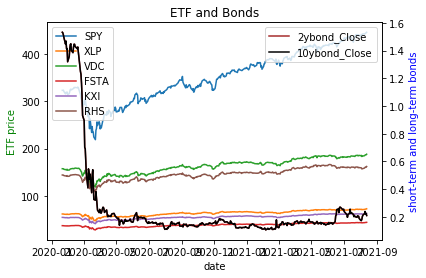

In [16]:
## plot relationship of ETF vs short-term (2yr) and long-term bonds (1yr)
## we tend to find that seasonality is poor.
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ETF_bonds_covid['Adj Close', 'SPY'],label='SPY')
ax1.plot(ETF_bonds_covid['Adj Close', 'XLP'],label='XLP')
ax1.plot(ETF_bonds_covid['Adj Close', 'VDC'],label='VDC')
ax1.plot(ETF_bonds_covid['Adj Close', 'FSTA'],label='FSTA')
ax1.plot(ETF_bonds_covid['Adj Close', 'KXI'],label='KXI')
ax1.plot(ETF_bonds_covid['Adj Close', 'RHS'],label='RHS')

ax2.plot(ETF_bonds_covid['2ybond_Close'],label='2ybond_Close',color='brown')
ax2.plot(ETF_bonds_covid['10ybond_Close'],label='10ybond_Close',color='black')


ax1.set_xlabel('date')
ax1.set_ylabel('ETF price', color='g')
ax2.set_ylabel('short-term and long-term bonds', color='b')
plt.title('ETF and Bonds')
ax1.legend(loc='best')
ax2.legend(loc='best')

plt.savefig('./Desktop/ETF and Bonds.jpg')

plt.show()

In [17]:
# 3.Beta analysis: how does Covid cases influence the beta of the ETFs
# the core idea is to use the speed of new covid cases as a proxy to inflation surprises
## and then study how does the beta of the sector (represented by ETF) evolve?
## we select 5 days as a window, and moves the window back to back in retrospect, this 
## avoids the seasonality in our data set and would not make very high serial correlation 
## as all the windows are non-overlapping

look_back_window = 5
ETF_list = ["SPY", "XLP" , "VDC" , "FSTA",  "KXI", "RHS"]
Bond_list = ["U.S. 2Y", "U.S. 10Y"]

In [18]:
ETF_dict = {}
for E in ETF_list:
    ETF_dict['{}'.format(E)] = yf.download('{}'.format(E),start="2020-01-21", end="2021-08-15")

Bond_dict = {}
for B in Bond_list:
    Bond_dict['{}'.format(B)] = investpy.get_bond_historical_data(bond='{}'.format(B), from_date='21/01/2020', to_date='15/08/2021')



ETF_Bonds_Beta = pd.DataFrame()
for E in ETF_list:
    for B in Bond_list:
        ETF_Bonds_Beta['{}'.format(E)] = ETF_dict['{}'.format(E)]['Adj Close']
        ETF_Bonds_Beta['{}'.format(B)] = Bond_dict['{}'.format(B)]['Close']
        ETF_Bonds_Beta['{}_{}_Beta'.format(E,B)] = 0
        for i in range(9, len(ETF_Bonds_Beta['{}'.format(E)])):
            ETF_Bonds_Beta['{}_{}_Beta'.format(E,B)].iloc[i] = ETF_Bonds_Beta['{}'.format(E)].iloc[i-look_back_window:i].corr(ETF_Bonds_Beta['{}'.format(B)].iloc[i-look_back_window:i])




Beta_weekly = []
for i in range(0, len(ETF_Bonds_Beta), look_back_window):
    Beta_weekly.append(ETF_Bonds_Beta.iloc[i])

Beta_weekly = pd.concat(Beta_weekly, axis = 1).T

Beta_weekly['SUM'] = 0
for E in ETF_list:
    for B in Bond_list:
        Beta_weekly['SUM'] += Beta_weekly['{}_{}_Beta'.format(E,B)]
Beta_weekly['AVG'] =  Beta_weekly['SUM'] / (len(ETF_list) * len(Bond_list))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
csv_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
us_covid = pd.read_csv(csv_url, parse_dates=True, index_col=0)
us_covid = us_covid.shift(15) # lag of 15 days
us_covid['weekly_cases'] = us_covid['cases'].rolling(look_back_window+2).sum()
us_covid['weekly_new_cases'] = us_covid['weekly_cases']-us_covid['weekly_cases'].shift(1)

us_covid_weekly = []
for date in Beta_weekly.index:
    us_covid_weekly.append(us_covid.loc[str(date)])
us_covid_weekly = pd.concat(us_covid_weekly, axis =1).T
us_covid_weekly['weekly_increase_rate'] = us_covid_weekly['weekly_new_cases'] / us_covid['weekly_cases'].shift(1)
us_covid_weekly['weekly_rate_of_increase_rate'] = (us_covid_weekly['weekly_new_cases'] - us_covid_weekly['weekly_new_cases'].shift(1))/us_covid_weekly['weekly_new_cases'].shift(1)
us_covid_weekly['log_weekly_rate_of_increase_rate'] = np.log(us_covid_weekly['weekly_rate_of_increase_rate'])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


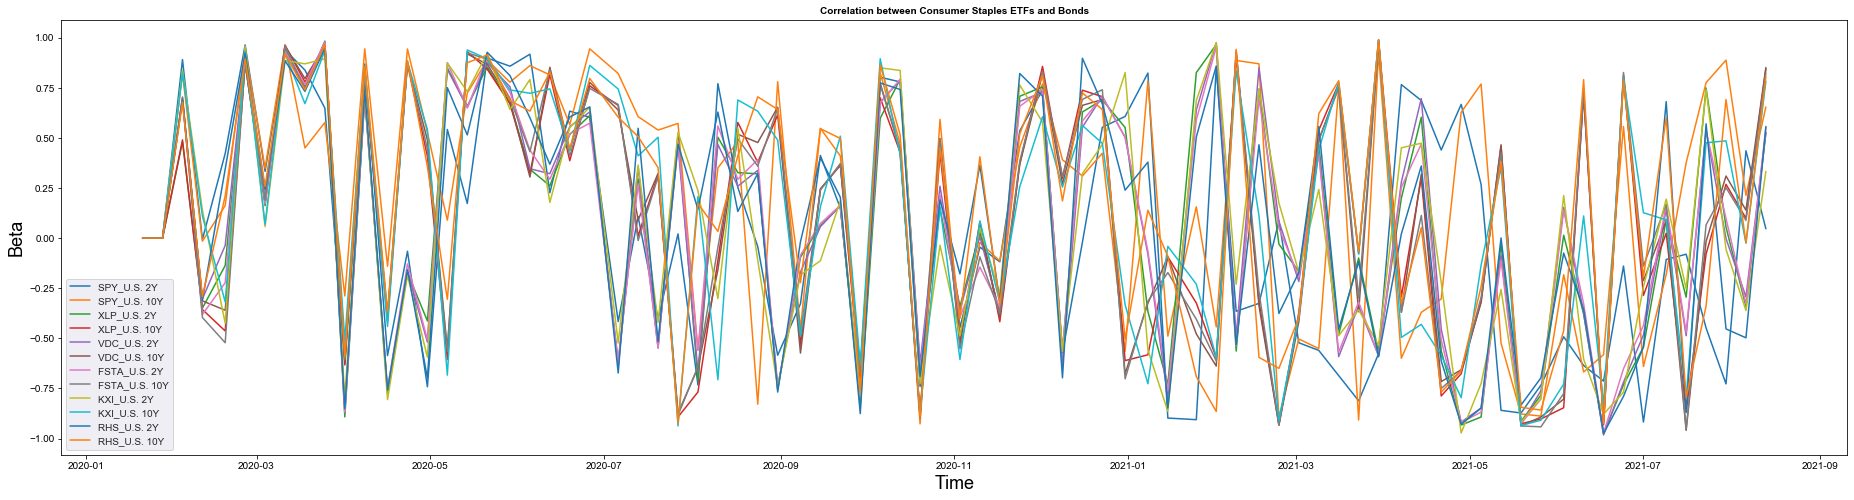

In [20]:
fig_beta, ax_beta = plt.subplots(figsize=(32, 8))
sns.set_style("darkgrid")
fig_title = 'Correlation between Consumer Staples ETFs and Bonds'
for E in ETF_list:
    for B in Bond_list:
        ax_beta = sns.lineplot(x = Beta_weekly.index, y = Beta_weekly['{}_{}_Beta'.format(E,B)], label = '{}_{}'.format(E,B))
ax_beta.set_title(fig_title, fontsize=10, fontweight="bold")
ax_beta.set_xlabel('Time', fontsize = 18)
ax_beta.set_ylabel('Beta', fontsize = 18)
plt.savefig('./Desktop/Correlation between Consumer Staples ETFs and Bonds.jpg')
plt.show()

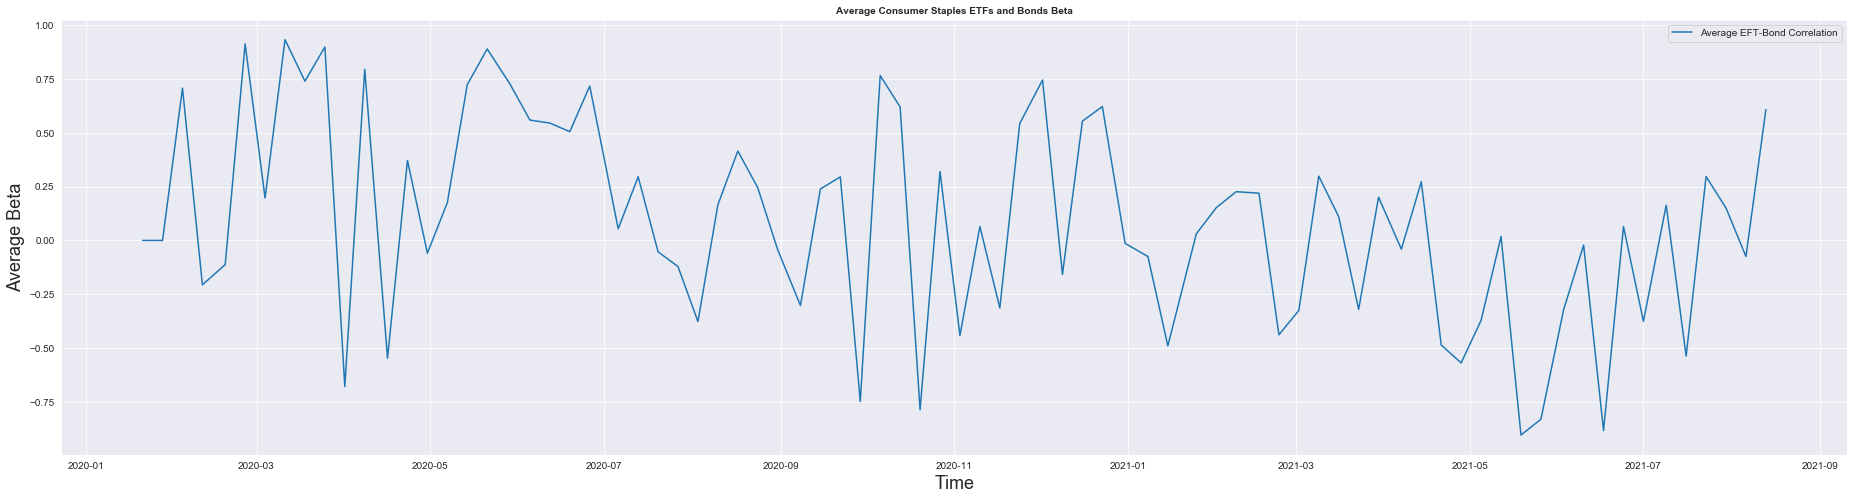

In [21]:
fig_avg, ax_avg = plt.subplots(figsize=(32, 8))
sns.set_style("darkgrid")
fig_title = 'Average Consumer Staples ETFs and Bonds Beta'
ax_avg = sns.lineplot(x = Beta_weekly.index, y = Beta_weekly['AVG'], label = 'Average EFT-Bond Correlation')
ax_avg.set_title(fig_title, fontsize=10, fontweight="bold")
ax_avg.set_xlabel('Time', fontsize = 18)
ax_avg.set_ylabel('Average Beta', fontsize = 18)
plt.savefig('./Desktop/Average Consumer Staples ETFs and Bonds Beta1.jpg')
plt.show()

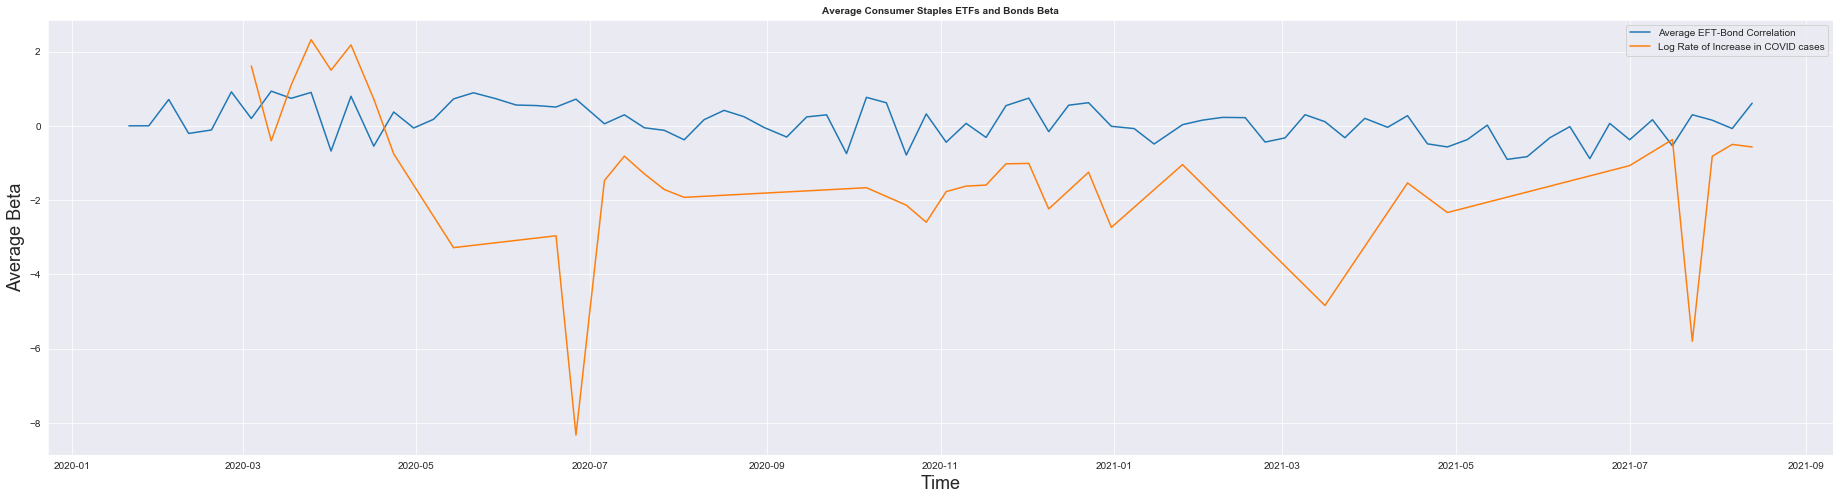

In [22]:
fig_avg, ax_avg = plt.subplots(figsize=(32, 8))
sns.set_style("darkgrid")
fig_title = 'Average Consumer Staples ETFs and Bonds Beta'
ax_avg = sns.lineplot(x = Beta_weekly.index, y = Beta_weekly['AVG'], label = 'Average EFT-Bond Correlation')
ax_avg = sns.lineplot(x= Beta_weekly.index, y = us_covid_weekly['log_weekly_rate_of_increase_rate'], label = 'Log Rate of Increase in COVID cases')
ax_avg.set_title(fig_title, fontsize=10, fontweight="bold")
ax_avg.set_xlabel('Time', fontsize = 18)
ax_avg.set_ylabel('Average Beta', fontsize = 18)
plt.savefig('./Desktop/Average Consumer Staples ETFs and Bonds Beta2.jpg')
plt.show()